In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/CIFAR-10/CIFAR-10_NonIID/PathologicalPartition/Decentralized/Pathological_Requirement.ipynb'

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

NUM_CLIENTS = 10
BATCH_SIZE = 32

from flwr_datasets.partitioner import PathologicalPartitioner

partitioner = PathologicalPartitioner(
    num_partitions=NUM_CLIENTS,
    partition_by="label",
    num_classes_per_partition=2,
    class_assignment_mode="random", # ['random', 'deterministic', 'first-deterministic']
    seed=42
)

def load_datasets(partition_id: int):
    fds=FederatedDataset(dataset="mnist", partitioners={"train": partitioner})
    partition=fds.load_partition(partition_id)

    print(f"Partition {partition_id} size: {len(partition)}")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    print(f"Partition {partition_id} train size: {len(partition_train_test['train'])}")
    print(f"Partition {partition_id} test size: {len(partition_train_test['test'])}")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))
        ]
    )
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    train_batch_size = min(BATCH_SIZE, max(2, len(partition_train_test["train"])))

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=train_batch_size,
        shuffle=True,
        drop_last=(len(partition_train_test["train"]) % train_batch_size == 1)
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        drop_last=(len(partition_train_test["test"]) == 1)
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        if v.size == 0:
            print(f"Warning: Parameter {k} is empty!")
            continue
        state_dict[k] = torch.tensor(v)

    net.load_state_dict(state_dict, strict=True)

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from flwr.server.strategy import FedAvgM # Federated average with momentum

test_accuracies = []

class CustomFedAvgM(FedAvgM):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [ ]:
strategy = CustomFedAvgM(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=ndarrays_to_parameters(params),
    server_learning_rate=1.0, # Learning rate
    server_momentum=0.9 # Momentum
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=1471) 2025-04-28 19:44:34.797551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1471) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1471) E0000 00:00:1745869474.839493    1471 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1471) E0000 00:00:1745869474.850116    1471 cuda_bla

(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 194424.67 examples/s]
(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.4078
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
Round 2: Test Accuracy: 0.4300
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
Round 3: Test Accuracy: 0.9596


INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
Round 4: Test Accuracy: 0.8645
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) 
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) 
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
Round 5: Test Accuracy: 0.6209
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
Round 6: Test Accuracy: 0.6129
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.5945
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.8009
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 9: Test Accuracy: 0.9119
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.9076
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 11: Test Accuracy: 0.9650
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 12: Test Accuracy: 0.8799
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.9357
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.9719
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.9766
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 16: Test Accuracy: 0.9799
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Accuracy: 0.9469
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Accuracy: 0.8927
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 19: Test Accuracy: 0.9605
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Accuracy: 0.9119
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Accuracy: 0.9084
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 22: Test Accuracy: 0.9021
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.9887
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.9821
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.9779
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.9634
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 27: Test Accuracy: 0.9846
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 28: Test Accuracy: 0.9808
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.9785
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.9792
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 31: Test Accuracy: 0.9075
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 32: Test Accuracy: 0.8883
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Accuracy: 0.8993
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Accuracy: 0.9379
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Accuracy: 0.9740
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 36: Test Accuracy: 0.9655
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Accuracy: 0.9596
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.9427
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Accuracy: 0.9891
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Test Accuracy: 0.9719
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
Round 41: Test Accuracy: 0.9861
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 42: Test Accuracy: 0.9831
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Accuracy: 0.9829
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Test Accuracy: 0.9036
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Accuracy: 0.9665
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 46: Test Accuracy: 0.8799
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
Round 47: Test Accuracy: 0.9593
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Accuracy: 0.9776
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Accuracy: 0.9779
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17732002671959008991, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) 
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15106610964941903228, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 8


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 8 size: 3016
(ClientAppActor pid=1471) Partition 8 train size: 2412
(ClientAppActor pid=1471) Partition 8 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 10432031254671643787, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 7


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 7 size: 9807
(ClientAppActor pid=1471) Partition 7 train size: 7845
(ClientAppActor pid=1471) Partition 7 test size: 1962
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16657743468516512154, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 16937939688088563200, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 0


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 0 size: 3020
(ClientAppActor pid=1471) Partition 0 train size: 2416
(ClientAppActor pid=1471) Partition 0 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 15573944897564910591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 1


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 1 size: 5987
(ClientAppActor pid=1471) Partition 1 train size: 4789
(ClientAppActor pid=1471) Partition 1 test size: 1198
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 1000822427918997492, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 2


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 2 size: 3947
(ClientAppActor pid=1471) Partition 2 train size: 3157
(ClientAppActor pid=1471) Partition 2 test size: 790
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17814188170518417084, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 640351823484374416, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 6


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(


(ClientAppActor pid=1471) Partition 6 size: 3965
(ClientAppActor pid=1471) Partition 6 train size: 3172
(ClientAppActor pid=1471) Partition 6 test size: 793
(ClientAppActor pid=1471) Context data: {'run_id': 7291026495283228678, 'node_id': 17578079413899864964, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1471)   array_records={},
(ClientAppActor pid=1471)   metric_records={},
(ClientAppActor pid=1471)   config_records={}
(ClientAppActor pid=1471) ), 'run_config': {}}
(ClientAppActor pid=1471) Using partition_id: 4


(ClientAppActor pid=1471) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1471)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 2855.96s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06100752595006085
INFO :      		round 2: 0.11274370920053826
INFO :      		round 3: 0.0066920061470807
INFO :      		round 4: 0.09706068374302318
INFO :      		round 5: 0.1259151501116243
INFO :      		round 6: 0.09036704392809096
INFO :      		round 7: 0.07521488542873597
INFO :      		round 8: 0.045010

(ClientAppActor pid=1471) Partition 4 size: 3017
(ClientAppActor pid=1471) Partition 4 train size: 2413
(ClientAppActor pid=1471) Partition 4 test size: 604
Round 50: Test Accuracy: 0.9654


INFO :      		round 12: 0.0246560588374284
INFO :      		round 13: 0.012794438819115697
INFO :      		round 14: 0.006173511460719755
INFO :      		round 15: 0.004890835838222903
INFO :      		round 16: 0.005519613514176873
INFO :      		round 17: 0.008429198318914291
INFO :      		round 18: 0.012181539119611886
INFO :      		round 19: 0.013244891763202697
INFO :      		round 20: 0.023837502054005033
INFO :      		round 21: 0.025254694905896675
INFO :      		round 22: 0.02932605420286213
INFO :      		round 23: 0.002991527663707499
INFO :      		round 24: 0.004089972518698755
INFO :      		round 25: 0.008886374434612541
INFO :      		round 26: 0.023361573205352464
INFO :      		round 27: 0.01188038819285432
INFO :      		round 28: 0.007746351097496688
INFO :      		round 29: 0.0038025085751751137
INFO :      		round 30: 0.005077208111058614
INFO :      		round 31: 0.018961733419147177
INFO :      		round 32: 0.05240616993408232
INFO :      		round 33: 0.04012154683170043
INFO :      		r

In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.4078
Round 2: 0.4300
Round 3: 0.9596
Round 4: 0.8645
Round 5: 0.6209
Round 6: 0.6129
Round 7: 0.5945
Round 8: 0.8009
Round 9: 0.9119
Round 10: 0.9076
Round 11: 0.9650
Round 12: 0.8799
Round 13: 0.9357
Round 14: 0.9719
Round 15: 0.9766
Round 16: 0.9799
Round 17: 0.9469
Round 18: 0.8927
Round 19: 0.9605
Round 20: 0.9119
Round 21: 0.9084
Round 22: 0.9021
Round 23: 0.9887
Round 24: 0.9821
Round 25: 0.9779
Round 26: 0.9634
Round 27: 0.9846
Round 28: 0.9808
Round 29: 0.9785
Round 30: 0.9792
Round 31: 0.9075
Round 32: 0.8883
Round 33: 0.8993
Round 34: 0.9379
Round 35: 0.9740
Round 36: 0.9655
Round 37: 0.9596
Round 38: 0.9427
Round 39: 0.9891
Round 40: 0.9719
Round 41: 0.9861
Round 42: 0.9831
Round 43: 0.9829
Round 44: 0.9036
Round 45: 0.9665
Round 46: 0.8799
Round 47: 0.9593
Round 48: 0.9776
Round 49: 0.9779
Round 50: 0.9654



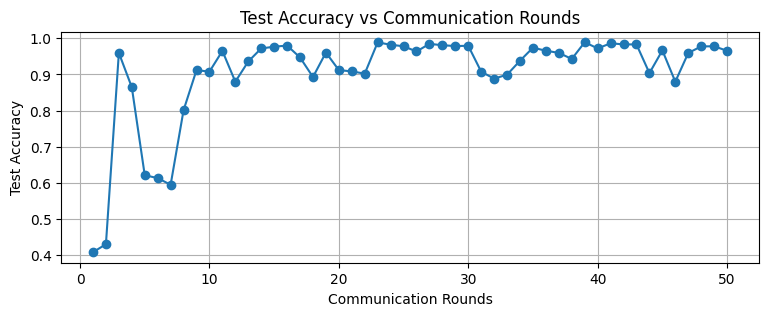

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()